In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Rand reps, model init fixed

In [2]:
import sys
sys.path.append('../../')

import denn.utils as ut

In [3]:
# folder = lambda i: f"/Users/dylanrandle/Downloads/POS_run_gan_053020_seed{i}/val_mse.npy"
# gan_reps = []
# for i in range(5):
#     gan_reps.append(np.load(folder(i)))
# gan_reps = np.vstack(gan_reps)

In [4]:
# gan_reps = np.load('/Users/dylanrandle/Downloads/pos_reps_052620_gan.npy')

gan_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/hea/hea_rand_reps_gan.npy')

l2_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/hea/hea_rand_reps_L2.npy')

l1_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/hea/hea_rand_reps_L1.npy')

huber_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/hea/hea_rand_reps_huber.npy')

In [5]:
gan_reps.shape, l2_reps.shape, l1_reps.shape, huber_reps.shape

((10, 4000), (10, 4000), (10, 4000), (10, 4000))

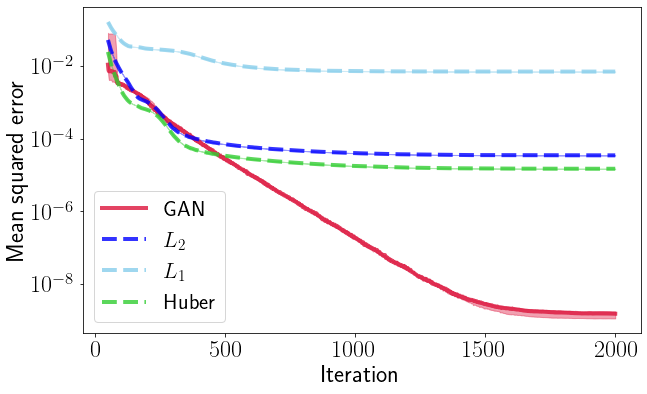

In [6]:
arrs_dict = {"GAN": gan_reps[:,:2000], 
             "$L_2$": l2_reps[:,:2000],
             "$L_1$": l1_reps[:,:2000], 
             "Huber": huber_reps[:,:2000],
#              "RK4": mse*np.ones_like(huber_reps)
            }
ut.plot_reps_results(arrs_dict, fname="hea_rand_reps.png",
                     window=50, figsize=(10,6), pctiles=(25,75), linewidth=4)

In [8]:
print(f"L1 Min: {np.min(l1_reps)}")
print(f"L2 Min: {np.min(l2_reps)}")
print(f"Huber Min: {np.min(huber_reps)}")
print(f"GAN Min: {np.min(gan_reps)}")

L1 Min: 0.006959317717701197
L2 Min: 3.4486816730350256e-05
Huber Min: 1.4623213246522937e-05
GAN Min: 6.718363643187786e-10


# Finite Diff

In [12]:
#! /usr/bin/env python3
#
def fd1d_heat_implicit_cfl ( k, t_num, t_min, t_max, x_num, x_min, x_max ):

#*****************************************************************************80
#
## fd1d_heat_implicit_cfl(): compute the Courant-Friedrichs-Loewy coefficient.
#
#  Discussion:
#
#    The equation to be solved has the form:
#
#      dUdT - k * d2UdX2 = F(X,T)
#
#    over the interval [X_MIN,X_MAX] with boundary conditions
#
#      U(X_MIN,T) = U_X_MIN(T),
#      U(X_MIN,T) = U_X_MAX(T),
#
#    over the time interval [T_MIN,T_MAX] with initial conditions
#
#      U(X,T_MIN) = U_T_MIN(X)
#
#    The code uses the finite difference method to approximate the
#    second derivative in space, and an explicit forward Euler approximation
#    to the first derivative in time.
#
#    The finite difference form can be written as
#
#      U(X,T+dt) - U(X,T)                  ( U(X-dx,T) - 2 U(X,T) + U(X+dx,T) )
#      ------------------  = F(X,T) + k *  ------------------------------------
#               dt                                   dx * dx
#
#    or, assuming we have solved for all values of U at time T, we have
#
#      U(X,T+dt) = U(X,T) + cfl * ( U(X-dx,T) - 2 U(X,T) + U(X+dx,T) ) + dt * F(X,T) 
#
#    Here "cfl" is the Courant-Friedrichs-Loewy coefficient:
#
#      cfl = k * dt / dx / dx
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license. 
#
#  Modified:
#
#    14 April 2017
#
#  Author:
# 
#    John Burkardt
#
#  Reference:
#
#    George Lindfield, John Penny,
#    Numerical Methods Using MATLAB,
#    Second Edition,
#    Prentice Hall, 1999,
#    ISBN: 0-13-012641-1,
#    LC: QA297.P45.
#
#  Input:
#
#    real K, the heat conductivity coefficient.
#
#    integer T_NUM, the number of time values, including the initial
#    value.
#
#    real T_MIN, T_MAX, the minimum and maximum times.
#
#    integer X_NUM, the number of nodes.
#
#    real X_MIN, X_MAX, the minimum and maximum spatial coordinates.
#
#  Output:
#
#    real CFL, the Courant-Friedrichs-Loewy coefficient.
#
    x_step = ( x_max - x_min ) / float ( x_num - 1 )
    t_step = ( t_max - t_min ) / float ( t_num - 1 )
    cfl = k * t_step / x_step / x_step

    return cfl

def fd1d_heat_implicit_matrix ( x_num, cfl ):

#*****************************************************************************80
#
## fd1d_heat_implicit_matrix(): set the system matrix.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    14 April 2017
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer X_NUM, the number of nodes.
#
#    real CFL, the Courant-Friedrichs-Loewy coefficient.
#
#  Output:
#
#    real A(X_NUM,X_NUM), the system matrix.
#

    a = np.zeros ( ( x_num, x_num ) )

    a[0,0] = 1.0

    for i in range ( 1, x_num - 1 ):
        a[i,i-1] =           - cfl
        a[i,i  ] = 1.0 + 2.0 * cfl
        a[i,i+1] =           - cfl

    a[x_num-1,x_num-1] = 1.0

    return a

def ic ( x_num, x, t ):

#*****************************************************************************80
#
## ic_test01() evaluates the initial condition for problem 1.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license. 
#
#  Modified:
#
#    25 January 2012
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer X_NUM, the number of nodes.
#
#    real X(X_NUM), the node coordinates.
#
#    real T, the initial time.
#
#  Output:
#
#    real H(X_NUM), the heat values at the initial time.
#

    h = np.sin(np.pi*x)

    return h

def bc ( x_num, x, t, h ):

#*****************************************************************************80
#
## bc_test01() evaluates the boundary conditions for problem 1.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license. 
#
#  Modified:
#
#    25 January 2012
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer X_NUM, the number of nodes.
#
#    real X(X_NUM), the node coordinates.
#
#    real T, the current time.
#
#    real H(X_NUM), the current heat values.
#
#  Output:
#
#    real H(X_NUM), the current heat values, after boundary
#    conditions have been imposed.
#
    h[0]       = 0.0
    h[x_num-1] = 0.0

    return h

def rhs ( x_num, x, t ):

#*****************************************************************************80
#
## rhs_test01() evaluates the right hand side for problem 1.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license. 
#
#  Modified:
#
#    25 January 2012
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer X_NUM, the number of nodes.
#
#    real X(X_NUM), the node coordinates.
#
#    real T, the current time.
#
#  Output:
#
#    real VALUE(X_NUM), the source term.
#

    value = np.zeros ( x_num )

    return value

def fd1d_heat_implicit ( a, x_num, x, t, dt, cfl, rhs_fun, bc_fun, u ):

#*****************************************************************************80
#
## fd1d_heat_implicit(): Finite difference solution of 1D heat equation.
#
#  Discussion:
#
#    fd1d_heat_implicit solves the 1D heat equation with an implicit method.
#
#    This program solves
#
#      dUdT - k * d2UdX2 = F(X,T)
#
#    over the interval [A,B] with boundary conditions
#
#      U(A,T) = UA(T),
#      U(B,T) = UB(T),
#
#    over the time interval [T0,T1] with initial conditions
#
#      U(X,T0) = U0(X)
#
#    The code uses the finite difference method to approximate the
#    second derivative in space, and an implicit backward Euler approximation
#    to the first derivative in time.
#
#    The finite difference form can be written as
#
#      U(X,T+dt) - U(X,T)                  ( U(X-dx,T+dt) - 2 U(X,T+dt) + U(X+dx,T+dt) )
#      ------------------ = F(X,T+dt) + k *  --------------------------------------
#               dt                                   dx * dx
#
#    so that we have the following linear system for the values of U at time T+dt:
#
#            -     k * dt / dx / dx   * U(X-dt,T+dt)
#      + ( 1 + 2 * k * dt / dx / dx ) * U(X,   T+dt)
#            -     k * dt / dx / dx   * U(X+dt,T+dt)
#      =               dt             * F(X,   T+dt)
#      +                                U(X,   T)
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    14 April 2017
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    real A(X_NUM,X_NUM), the system matrix.
#
#    integer X_NUM, the number of nodes.
#
#    real X(X_NUM), the node coordinates.
#
#    real T, the current time.
#
#    real DT, the size of the time step.
#
#    real CFL, the Courant-Friedrichs-Loewy coefficient.
#
#    f = rhs_FUN ( x_num, x, t ), returns in F the right hand side
#    forcing function at every non-boundary node.
#
#    hbc = bc_FUN ( x_num, x, t, h ), returns in HBC a copy of the
#    input solution H, after imposing Dirichlet boundary conditions.
#
#    real U(X_NUM), the solution values at the old time.
#
#  Output:
#
#    real U(X_NUM), the solution values at the new time.
#
#
#  Compute b, the right hand side of the system.
#
    fvec = rhs_fun ( x_num, x, t )

    b = u.copy ( )
    for i in range ( 1, x_num - 1 ):
        b[i] = b[i] + dt * fvec[i]
#
#  Solve A*u=b.
#
    u = np.linalg.solve ( a, b )
#
#  Impose boundary conditions on U.
#
    u = bc_fun ( x_num, x, t, u )

    return u


  Number of X nodes = 32
  X interval is [0.000000,1.000000]
  X spacing is 0.032258
  Number of T values = 32
  T interval is [0.000000,0.200000]
  T spacing is 0.006452
  Constant K = 1
  CFL coefficient = 6.2


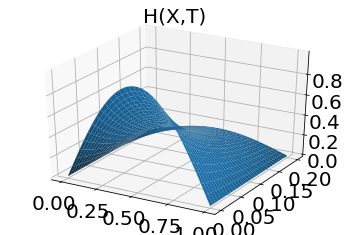

In [15]:
k = 1
#
#  X_NUM is the number of equally spaced nodes to use between 0 and 1.
#
x_num = 32
x_min = 0.0
x_max = 1.0
dx = ( x_max - x_min ) / ( x_num - 1 )
x = np.linspace ( x_min, x_max, x_num )
#
#  T_NUM is the number of equally spaced time points between 0 and 10.0.
#
t_num = 32
t_min = 0.0
t_max = 0.2
dt = ( t_max - t_min ) / ( t_num - 1 )
t = np.linspace ( t_min, t_max, t_num )
#
#  Compute the CFL coefficient.
#
cfl = fd1d_heat_implicit_cfl ( k, t_num, t_min, t_max, x_num, x_min, x_max )

print ( '' )
print ( '  Number of X nodes = %d' % ( x_num ) )
print ( '  X interval is [%f,%f]' % ( x_min, x_max ) )
print ( '  X spacing is %f' % ( dx ) )
print ( '  Number of T values = %d' % ( t_num ) )
print ( '  T interval is [%f,%f]' % ( t_min, t_max ) )
print ( '  T spacing is %f' % ( dt ) )
print ( '  Constant K = %g' % ( k ) )
print ( '  CFL coefficient = %g' % ( cfl ) )
#
#  Compute the system matrix.
#
a = fd1d_heat_implicit_matrix ( x_num, cfl )
#
#  Save every solution vector H in a matrix HMAT, for plotting.
#
hmat = np.zeros ( ( x_num, t_num ) )
#
#  Compute T_NUM solutions (including the initial condition).
#
for j in range ( 0, t_num ):

    if ( j == 0 ):
        h = ic ( x_num, x, t[j] )
        h = bc ( x_num, x, t[j], h )
    else:
        h = fd1d_heat_implicit ( a, x_num, x, t[j-1], dt, cfl, rhs, bc, h )

    for i in range ( 0, x_num ):
        hmat[i,j] = h[i]
    #
#  Plot X and T versus H.
#
tmat, xmat = np.meshgrid ( t, x )
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface ( xmat, tmat, hmat )
plt.title ( 'H(X,T)' )
plt.show ()

In [16]:
hmat.shape

(32, 32)

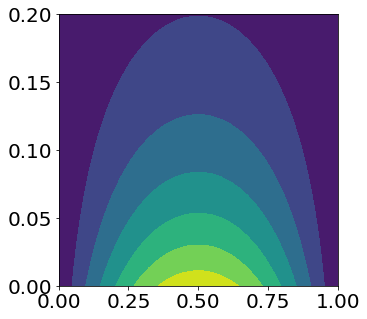

In [17]:
plt.figure(figsize=(5,5))
plt.contourf(xmat, tmat, hmat)

In [18]:
def anal_sol(x, t):
    return np.exp(-t*np.pi**2)*np.sin(np.pi*x)

In [19]:
U_an = anal_sol(xmat, tmat)

In [20]:
U_an.shape

(32, 32)

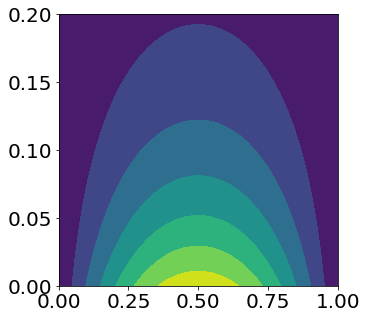

In [22]:
plt.figure(figsize=(5,5))
plt.contourf(xmat, tmat, U_an)

In [21]:
np.mean((hmat - U_an)**2)

4.620835946153414e-05